In [1]:
# default_exp models

# Import

In [2]:
#export
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace
from torch.utils.data import DataLoader

from fiducial_detect.data import *

# Utility

In [3]:
#export
def get_out_channels(m):
    # Gets out_channels of last conv layer
    out_channels = None
    for m_sub in m.modules():
        if isinstance(m_sub, nn.modules.conv._ConvNd):
            out_channels = m_sub.out_channels
    return out_channels

In [4]:
#export
def conv_layer(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, 
                  out_channels, 
                  kernel_size=kernel_size, 
                  stride=stride, 
                  padding=padding, 
                  bias=False), # No bias needed since learnable affine params in norm layer
        nn.GroupNorm(1, out_channels),
        nn.ReLU(inplace=True)
    )

In [5]:
#export
def up_conv_layer(in_channels, out_channels, kernel_size, stride, padding, scale_factor):
    return nn.Sequential(
        conv_layer(in_channels, out_channels, kernel_size, stride, padding),
        nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
    )

In [6]:
#export
def get_encoder(in_channels, layout_encoder):
    prev_out_channels = in_channels
    encoder = []
    for layout_layer in layout_encoder:
        layer = []
        for layout_conv in layout_layer:
            layer.append(conv_layer(prev_out_channels, *layout_conv))
            prev_out_channels = layout_conv[0]
        encoder.append(nn.Sequential(*layer))
    return nn.Sequential(*encoder)

# Models

In [7]:
#export
class UNET(nn.Module):
    def __init__(self, encoder, out_channels):
        super(UNET, self).__init__()
        self.encoder = encoder
        self.decoder = self._get_decoder(encoder)
        self.last_conv = nn.Conv2d(get_out_channels(self.decoder), 
                                   out_channels, 
                                   kernel_size=3, 
                                   stride=1, 
                                   padding=1)
        
    def _get_decoder(self, encoder):
        # Assumes each level of encoder shrinks by a factor of 2
        decoder = []
        for i in reversed(range(len(encoder))):
            in_channels = get_out_channels(encoder[i])
            if len(decoder) > 0: 
                in_channels += get_out_channels(decoder[-1])
            decoder.append(up_conv_layer(in_channels,
                                         get_out_channels(encoder[i])//2,
                                         kernel_size=3,
                                         stride=1,
                                         padding=1,
                                         scale_factor=2))
        return nn.Sequential(*decoder)

    def forward(self, X):
        Xs = [X]
        for conv_down in self.encoder:
            Xs.append(conv_down(Xs[-1]))
        X = Xs[-1][:,0:0,:,:] # Empty, but same size and dimension as last X
        for idx, conv_up in enumerate(self.decoder):
            X = conv_up(torch.cat([X, Xs[-(idx+1)]], dim=1))
        return self.last_conv(X)

### Test

In [8]:
in_channels = 1
out_channels = 5

# [out_channels, kernel_size, stride, padding]
layout_encoder = [[[48,5,2,2]],
                  [[48,3,1,1],[48,3,2,1]],
                  [[60,3,1,1],[60,3,2,1]],
                  [[72,3,1,1],[144,3,2,1]]]

model = UNET(get_encoder(in_channels, layout_encoder), out_channels)
model

UNET(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 48, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (1): GroupNorm(1, 48, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): GroupNorm(1, 48, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): GroupNorm(1, 48, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(48, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): GroupNorm(1, 60, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(60, 60, kernel_size=

In [9]:
tfms = Compose([Resize((512, 384)), 
                Normalize((0, 1), (-1, 1)),
                RandomContrast((0.5, 1.5), 1, 0.33),
                RandomBrightness((-0.5, 0.5), 0, 0.33),
                RandomBlur((0, 1.5), 0.50, 0.50),
                Random(Noise((-0.25, 0.25), 0, 0.1), 0.9),
                Random(RandomGrad((-0.5, 0.5))     , 0.9),
                Clip((-1,1)),
                ToTensor()])

ds_mask_synth = SyntheticMaskDataSet(tfms=tfms)

In [10]:
batch_size = 16
num_workers = 4
pin_memory = True

dl_mask_synth = DataLoader(ds_mask_synth, 
                           batch_size=batch_size,
                           num_workers=num_workers,
                           pin_memory=pin_memory,
                           worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

In [11]:
X,y = next(iter(dl_mask_synth))

In [12]:
X.shape, y.shape

(torch.Size([16, 1, 384, 512]), torch.Size([16, 384, 512]))

In [13]:
X.mean(dim=(2,3)).mean(), X.std(dim=(2,3)).mean()

(tensor(0.1897), tensor(0.4133))

In [14]:
y_hat = model(X)
y_hat.shape

torch.Size([16, 5, 384, 512])

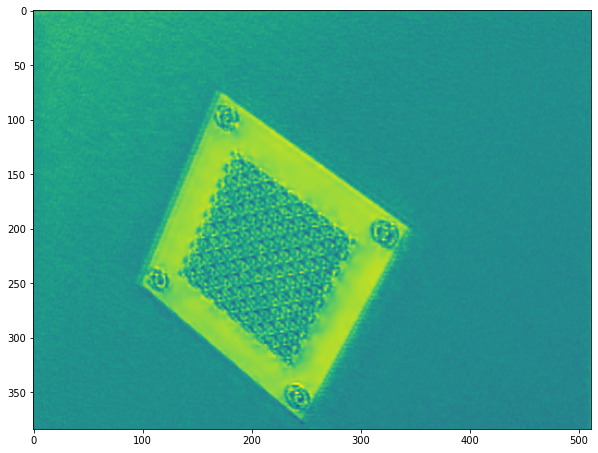

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(y_hat[0, 0, :, :].detach().numpy(), vmin=-1, vmax=1)

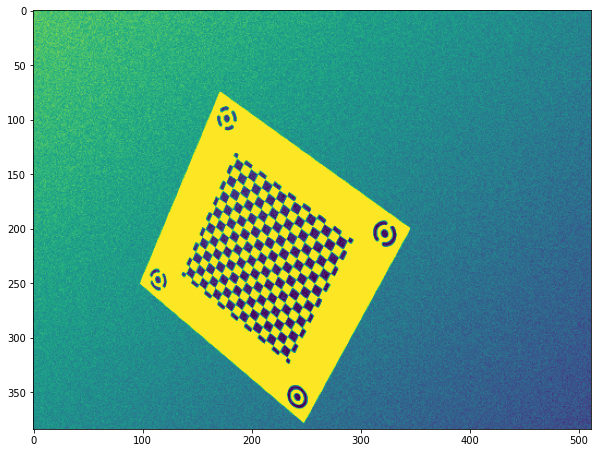

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(X[0, 0, :, :].detach().numpy(), vmin=-1, vmax=1)

# Build

In [17]:
!nbdev_build_lib

Converted data.ipynb.
Converted gen_cb.ipynb.
Converted models.ipynb.
